In [1]:
import matplotlib.pyplot as plt

import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch

from neurovlm.data import data_dir
from neurovlm.models import Specter
from neurovlm.train import which_device
from neurovlm.metrics import recall_curve

from sklearn.metrics import auc

## Computing latents

In [3]:
# Load specter
device = which_device()
specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query", device=device)
proj_head = torch.load(data_dir / f"proj_head_text_infonce.pt", weights_only=False, map_location=device)
df_pubs = pd.read_csv(data_dir / "neuro_vault_brain_to_text.csv")

There are adapters available but none are activated for the forward pass.


In [4]:
nv = torch.load(data_dir / "neurovault.pt", weights_only=False)
df_nv = nv["df_pubs"]
assert (df_nv["doi"].values == df_pubs["doi"].values).all()

In [5]:
with torch.no_grad():
    text_emb = F.normalize(proj_head(F.normalize(nv["text_emb_titles_abstracts"].to(device))), dim=1)
    text_emb_gen = F.normalize(proj_head(F.normalize(specter(df_pubs["brain_to_text_summary"].tolist()), dim=1)), dim=1)

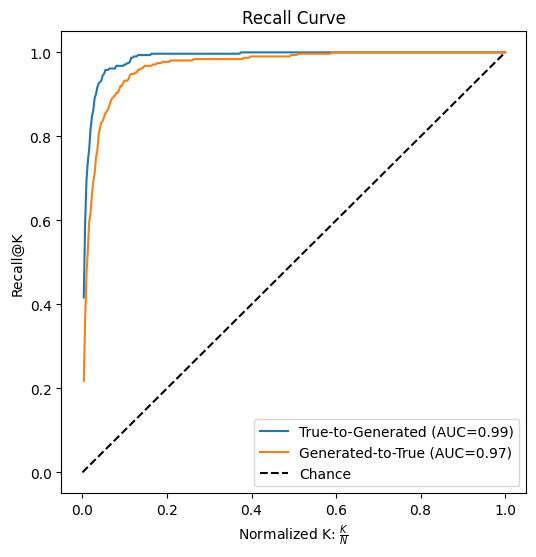

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))

t_to_i, i_to_t = recall_curve(text_emb.cpu(), text_emb_gen.cpu())
x = np.arange(1, len(t_to_i)+1) / len(t_to_i)
ax.plot(x, t_to_i, label=f"True-to-Generated (AUC={round(auc(x, t_to_i), 2)})", color="C0")
ax.plot(x, i_to_t, label=f"Generated-to-True (AUC={round(auc(x, i_to_t), 2)})", color="C1")

ax.set_ylabel("Recall@K")
ax.set_xlabel(r"Normalized K: $\frac{K}{N}$")
ax.set_title("Recall Curve")
ax.plot([0, 1], [0, 1], color='k', ls='--', label="Chance")
ax.legend(loc="lower right")
plt.savefig(data_dir / "contrastive_recall_gen.png", dpi=300)